In [1]:
import pandas as pd
from biodata.delimited import DelimitedWriter
import numpy as np
import pybedtools
from biodatatools.utils.common import json_load
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import subprocess
from mphelper import ProcessWrapPool
from statsmodels.stats import multitest
from pathlib import Path

In [2]:
font_dir = Path.cwd().parent / "font"
for font in ["Arial.ttf", "Arial_Bold.ttf"]:
    matplotlib.font_manager.fontManager.addfont(font_dir / font)
matplotlib.rcParams["font.family"] = "Arial"
bfontsize = 12
sfontsize = 9

In [3]:
PROJECT_DIR_d = "/home/yc2553/projects/HEA/databases/"
PROJECT_DIR_s = "/fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/"
PROJECT_DIR_o = "/fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/"
PROJECT_DIR_o2 = "/home/yc2553/projects/HEA/output/"

# Data preparation

In [4]:
labels = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/classifications.json")
groups = json_load(f"{PROJECT_DIR_d}PROcap/metainfo/samples.json")

In [5]:
# For normal tissue samples, only keep those highlighted in Fig.2A

inputfile = f"{PROJECT_DIR_d}PROcap/metainfo/keep_samples.txt"
samples_keep = list(pd.read_table(inputfile, header=None)[0])

In [6]:
# T1D patients
samples = groups["T1D"].copy()
# Normal blood samples
samples.extend([s for s in samples_keep if labels[s][1]=="Blood" and "PBMC" not in labels[s][0]])
# Pancreas samples for T2D analysis
samples.extend([s for s in samples_keep if labels[s][1]=="Pancreas"])
len(samples)

20

In [7]:
labels2 = {}
for s in samples:
    if labels[s][0] == "Natural killer cells":
        label = "NK cells"
    elif labels[s][0] == "T cells from T1D donor":
            label = "T1D T cells"
    elif labels[s][1] == "Pancreas":
        label = labels[s][1]
    else:
        label = labels[s][0]
    labels2[s] = label

## Create an annot file

In [8]:
# Focus on divergent distal elements found in these samples
# Extend 1kb to both sides from center 

p = "divergent"
d = "distal"
extension = 1000
outdir = f"{PROJECT_DIR_o}LDSC/annots/blood_{extension}/"

In [9]:
inputfile = f"{PROJECT_DIR_d}PROcap/processed/binary_{p}_{d}.txt"
df = pd.read_table(inputfile, index_col=0)
for s in samples:
	es = list(df[df[[s]].sum(axis=1) >= 1].index)
	outputfile = f"{outdir}{p}_{d}_{s}.bed"
	with DelimitedWriter(outputfile) as dw:
		for e in es:
			chrom, start, end = e.split("_")
			center = (int(end)+int(start))//2
			dw.write([chrom, center-extension, center+extension])
	b = pybedtools.BedTool(outputfile).sort().saveas(outputfile)

In [10]:
script = "/home/yc2553/slurm/LDSC/get_annotations.sh"
bim_prefix = f"{PROJECT_DIR_s}hg38/plink_files/1000G.EUR.hg38"

for s in samples:
	bed_file = f"{outdir}{p}_{d}_{s}.bed"
	annot_prefix = f"{outdir}{p}_{d}_{s}"
	commands = " ".join(["sbatch", script,
						bed_file,
						bim_prefix,
						annot_prefix
						])
	print(commands)

sbatch /home/yc2553/slurm/LDSC/get_annotations.sh /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/LDSC/annots/blood_1000/divergent_distal_T1D15.bed /fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/hg38/plink_files/1000G.EUR.hg38 /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/LDSC/annots/blood_1000/divergent_distal_T1D15
sbatch /home/yc2553/slurm/LDSC/get_annotations.sh /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/LDSC/annots/blood_1000/divergent_distal_T1D18.bed /fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/hg38/plink_files/1000G.EUR.hg38 /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/LDSC/annots/blood_1000/divergent_distal_T1D18
sbatch /home/yc2553/slurm/LDSC/get_annotations.sh /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/LDSC/annots/blood_1000/divergent_distal_T1D24.bed /fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/hg38/plink_files/1000G.EUR.hg38 /fs/cbsuhy02/storage/yc2553/yc2553/pr

## Computing LD scores with an annot file

In [37]:
script = "/home/yc2553/slurm/LDSC/get_LD_scores.sh"
bfile_prefix = f"{PROJECT_DIR_s}hg38/plink_files/1000G.EUR.hg38"
snps = f"{PROJECT_DIR_s}other_data/w_hm3_no_header.snplist"
for s in samples:
	annot_prefix = f"{outdir}{p}_{d}_{s}"
	commands = " ".join(["sbatch", script,
						bfile_prefix,
						annot_prefix,
						snps
						])
	print(commands)

sbatch /home/yc2553/slurm/LDSC/get_LD_scores.sh /fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/hg38/plink_files/1000G.EUR.hg38 /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/LDSC/annots/blood_1000/divergent_distal_T1D15 /fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/other_data/w_hm3_no_header.snplist
sbatch /home/yc2553/slurm/LDSC/get_LD_scores.sh /fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/hg38/plink_files/1000G.EUR.hg38 /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/LDSC/annots/blood_1000/divergent_distal_T1D18 /fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/other_data/w_hm3_no_header.snplist
sbatch /home/yc2553/slurm/LDSC/get_LD_scores.sh /fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/hg38/plink_files/1000G.EUR.hg38 /fs/cbsuhy02/storage/yc2553/yc2553/projects/3.Human_atlas/output/LDSC/annots/blood_1000/divergent_distal_T1D24 /fs/cbsuhy02/storage/yc2553/yc2553/softwares/ldsc/other_data/w_hm3_no_header.snplist
sbatch /home/yc2553/sl

# Heritability enrichment

## Blood traits

In [31]:
# Focus on normal blood samples

samples2 = [s for s in samples if labels2[s] not in ["T1D T cells", "Pancreas"]]
len(samples2)

9

In [36]:
outdir2 = f"{PROJECT_DIR_o}LDSC/cts/blood_1000/"

In [30]:
outputfile = f"{outdir2}{p}_{d}/cts_blood.txt"
with DelimitedWriter(outputfile) as dw:
	for s in samples2:
		dw.write([f"{p}_{d}_{s}", f"{outdir}/{p}_{d}_{s}."])

In [31]:
def get_cts(sumstat, ref_ld_chr, ref_ld_chr_cts, w_ld_chr, output_prefix):
	script = "/home/yc2553/slurm/LDSC/cell_type_specificity.sh"
	commands = " ".join(["bash", script,
						sumstat,
						ref_ld_chr,
						ref_ld_chr_cts,
						w_ld_chr,
						output_prefix
						])
	subprocess.run(commands, shell=True)

In [9]:
# Focus on these phenotypes

sumstats = ["UKB_460K.blood_WHITE_COUNT", "UKB_460K.blood_MONOCYTE_COUNT", "UKB_460K.blood_LYMPHOCYTE_COUNT",
            "PASS_IBD_deLange2017", "PASS_IBD", 
            "PASS_UC_deLange2017", "PASS_Ulcerative_Colitis",
            "PASS_CD_deLange2017", "PASS_Crohns_Disease"
           ]

In [33]:
pwpool = ProcessWrapPool(10)

ref_ld_chr = f"{PROJECT_DIR_s}hg38/baseline_v1.2/baseline."
w_ld_chr = f"{PROJECT_DIR_s}hg38/weights/weights.hm3_noMHC."
ref_ld_chr_cts = f"{outdir2}{p}_{d}/cts_blood.txt"
for sid in sumstats:
	output_prefix = f"{outdir2}{p}_{d}/{sid}.blood"
	pwpool.run(get_cts, args=[f"{PROJECT_DIR_s}all_sumstats/{sid}.sumstats", ref_ld_chr, ref_ld_chr_cts, w_ld_chr, output_prefix])

In [26]:
len(pwpool.finished_tasks)

In [218]:
pwpool.close()

In [13]:
dfs = []
for sid in sumstats:
    inputfile = f"{outdir2}{p}_{d}/{sid}.blood.cell_type_results.txt"
    df = pd.read_table(inputfile)
    df["Pheno"] = sid
    dfs.append(df)
df_all = pd.concat(dfs, ignore_index=True)
df_all["FDR"] = multitest.fdrcorrection(list(df_all["Coefficient_P_value"]), alpha=0.05, method="indep", is_sorted=False)[1]
df_all["-log10adjp"] = -np.log10(df_all["FDR"])

In [14]:
results = []
for s in samples2:
	for sid in sumstats:
		df = df_all[(df_all["Name"]==f"{p}_{d}_{s}") & (df_all["Pheno"]==sid)]
		row = [s, sid, list(df["-log10adjp"])[0], labels2[s]]
		results.append(row)
df_FDR = pd.DataFrame(results, columns=["type", "pheno", "-log10adjp", "group"])
df_FDR.head(2)

,type,pheno,-log10adjp,group
0,B1,UKB_460K.blood_WHITE_COUNT,2.103586,Monocytes
1,B1,UKB_460K.blood_MONOCYTE_COUNT,2.724220,Monocytes


In [15]:
FDR_cutoff = 0.1

In [16]:
order = ["Pan T cells", "Helper T cells", "Cytotoxic T cells", "B cells", "NK cells", "Monocytes"]
palette = ["#fb8072", "#fdb462", "#bc80bd", "#80b1d3", "#bebada", "#b3de69"]

In [17]:
def plot_individual_pheno(df, title, ylabel, ax, order, palette, xticklabels=True, ylim=None):
    g = sns.stripplot(df, x="group", y="-log10adjp", order=order, 
                      hue="group", hue_order=order, palette=palette, 
                      size=4.5, ax=ax)
    sns.barplot(df, x="group", y="-log10adjp", order=order, 
                      hue="group", hue_order=order, palette=palette, 
                      fill=False, errorbar=None, width=0.6, linewidth=0.8, ax=ax)
    g.axhline(y=-np.log10(FDR_cutoff), ls="--", c="grey")
    g.spines[["top","right"]].set_visible(False)
    g.set_title(title, fontsize=bfontsize, y=1.05)
    
    g.set_xlabel("")
    if xticklabels:
        for label in g.get_xticklabels():
            label.set_rotation(30)
            label.set_ha("right")
            label.set_fontsize(bfontsize)
    else:
        g.set_xticklabels([])
    
    g.set_ylabel(ylabel, fontsize=bfontsize)
    g.tick_params(axis="y", labelsize=sfontsize)    
    
    if ylim:
        g.set_ylim(ylim)

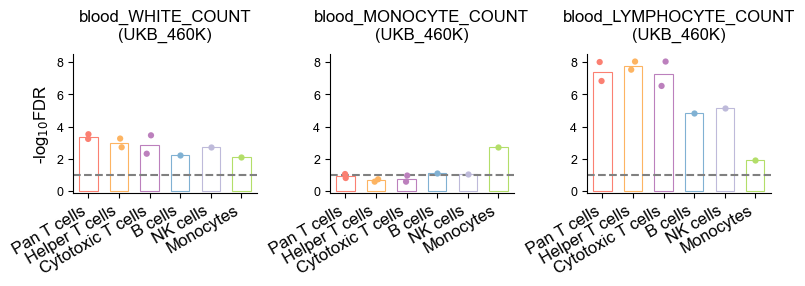

In [18]:
# Highlight blood count phenotypes

fig, axes = plt.subplots(1,3,figsize=(9,1.8))
selected = ["UKB_460K.blood_WHITE_COUNT", "UKB_460K.blood_MONOCYTE_COUNT", "UKB_460K.blood_LYMPHOCYTE_COUNT"]
for sid in selected:
    col = selected.index(sid)   
    ylabel = "-log$_{10}$FDR" if col == 0 else ""
    plot_individual_pheno(df_FDR[df_FDR["pheno"]==sid], f"{sid.split('.')[1]}\n({sid.split('.')[0]})", ylabel, axes[col], order, palette, True, [-0.1, 8.5])
plt.subplots_adjust(wspace=0.4)
plt.savefig(f"{PROJECT_DIR_o2}figures/ExtDataFig5a.pdf", bbox_inches='tight', transparent=True)

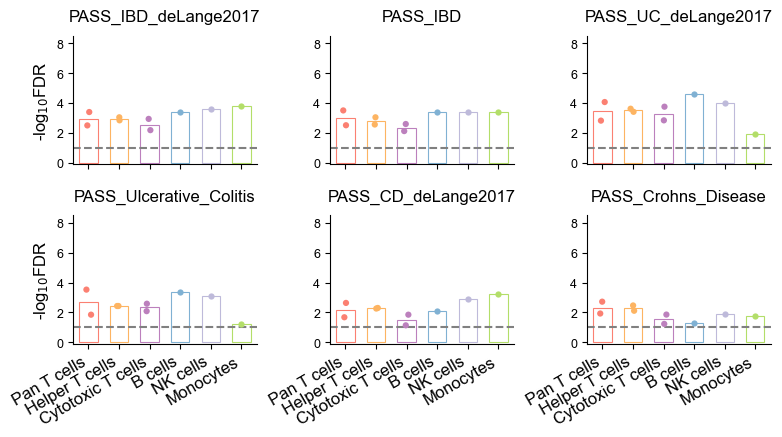

In [24]:
# Highlight IBD phenotypes

fig, axes = plt.subplots(2,3,figsize=(9,4))
selected = ["PASS_IBD_deLange2017", "PASS_IBD", 
            "PASS_UC_deLange2017", "PASS_Ulcerative_Colitis",
            "PASS_CD_deLange2017", "PASS_Crohns_Disease"]
for sid in selected:
	row = selected.index(sid) // 3
	col = selected.index(sid) % 3
	ylabel = "-log$_{10}$FDR" if col == 0 else ""
	xticklabels = True if row == 1 else False
	plot_individual_pheno(df_FDR[df_FDR["pheno"]==sid], sid, ylabel, axes[row, col], order, palette, xticklabels, [-0.1, 8.5])
plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.savefig(f"{PROJECT_DIR_o2}figures/ExtDataFig5b.pdf", bbox_inches='tight', transparent=True)

## Diabetes

In [34]:
# T1D vs. T2D

sumstats2 = ['PASS_Type_1_Diabetes', 'UKB_460K.disease_T2D', 'PASS_Type_2_Diabetes']

In [229]:
outputfile = f"{outdir2}{p}_{d}/cts_T1D.txt"
with DelimitedWriter(outputfile) as dw:
	for s in samples:
		dw.write([f"{p}_{d}_{s}", f"{outdir}{p}_{d}_{s}."])

In [230]:
pwpool = ProcessWrapPool(20)

ref_ld_chr = f"{PROJECT_DIR_s}hg38/baseline_v1.2/baseline."
w_ld_chr = f"{PROJECT_DIR_s}hg38/weights/weights.hm3_noMHC."
ref_ld_chr_cts = f"{outdir2}{p}_{d}/cts_T1D.txt"
for sid in sumstats2:
	output_prefix = f"{outdir2}{p}_{d}/{sid}.T1D"
	pwpool.run(get_cts, args=[f"{PROJECT_DIR_s}all_sumstats/{sid}.sumstats", ref_ld_chr, ref_ld_chr_cts, w_ld_chr, output_prefix])

In [32]:
len(pwpool.finished_tasks)

In [234]:
pwpool.close()

In [37]:
dfs = []
for sid in sumstats2:
	inputfile = f"{outdir2}{p}_{d}/{sid}.T1D.cell_type_results.txt"
	df = pd.read_table(inputfile)
	df["Pheno"] = sid
	dfs.append(df)
df_all2 = pd.concat(dfs, ignore_index=True)
df_all2["FDR"] = multitest.fdrcorrection(list(df_all2["Coefficient_P_value"]), alpha=0.05, method="indep", is_sorted=False)[1]
df_all2["-log10adjp"] = -np.log10(df_all2["FDR"])

In [38]:
results = []
for s in samples:
	for sid in sumstats2:
		df = df_all2[(df_all2["Name"]==f"{p}_{d}_{s}") & (df_all2["Pheno"]==sid)]
		row = [s, sid, list(df["-log10adjp"])[0], labels2[s]]
		results.append(row)
df_FDR2 = pd.DataFrame(results, columns=["type", "pheno", "-log10adjp", "group"])
df_FDR2.head(2)

,type,pheno,-log10adjp,group
0,T1D15,PASS_Type_1_Diabetes,1.830384,T1D T cells
1,T1D15,UKB_460K.disease_T2D,0.017378,T1D T cells


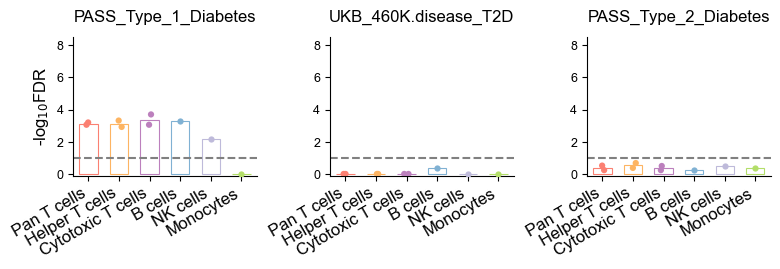

In [39]:
fig, axes = plt.subplots(1,3,figsize=(9,1.8))
for sid in sumstats2:
    col = sumstats2.index(sid)   
    ylabel = "-log$_{10}$FDR" if col == 0 else ""
    plot_individual_pheno(df_FDR2[df_FDR2["pheno"]==sid], sid, ylabel, axes[col], order, palette, True, [-0.1, 8.5])
plt.subplots_adjust(wspace=0.4)
plt.savefig(f"{PROJECT_DIR_o2}figures/ExtDataFig5c.pdf", bbox_inches='tight', transparent=True)

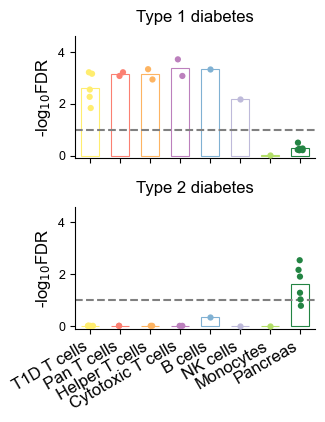

In [42]:
# For main figure

order2 = ["T1D T cells", "Pan T cells", "Helper T cells", "Cytotoxic T cells", "B cells", "NK cells", "Monocytes", "Pancreas"]
palette2 = ["#ffed6f", "#fb8072", "#fdb462", "#bc80bd", "#80b1d3", "#bebada", "#b3de69", "#238443"]
fig, axes = plt.subplots(2,1,figsize=(3.1,3.8))
sumstats3 = ['PASS_Type_1_Diabetes', 'UKB_460K.disease_T2D']
for sid in sumstats3:
	row = sumstats3.index(sid)
	title = "Type 1 diabetes" if sid == "PASS_Type_1_Diabetes" else "Type 2 diabetes"
	xticklabels = True if row == 1 else False
	plot_individual_pheno(df_FDR2[df_FDR2["pheno"]==sid], title, "-log$_{10}$FDR", axes[row], order2, palette2, xticklabels, [-0.1, 4.6])
plt.subplots_adjust(hspace=0.4)
plt.savefig(f"{PROJECT_DIR_o2}figures/Fig2d.pdf", bbox_inches='tight', transparent=True)